- for object detection model, create dataset for YOLO. \forObjectDetect_PACSDataInLabelmeFormatConvert2YoloFormat
- eton@250104
- ref: https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#option-2-create-a-manual-dataset


## 1. Create dataset.yaml
dataset.yaml is the dataset config file that defines 1) the dataset root directory path and relative paths to train / val / test image directories (or *.txt files with image paths) and 2) a class names dictionary:
```
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/coco128 # dataset root dir
train: images/train2017 # train images (relative to 'path') 128 images
val: images/train2017 # val images (relative to 'path') 128 images
test: # test images (optional)

# Classes (80 COCO classes)
names:
    0: person
    1: bicycle
    ...
```

## 2. Create Labels
After using an annotation tool to label your images, export your labels to YOLO format, with one *.txt file per image (if no objects in image, no *.txt file is required). The *.txt file specifications are:

- One row per object
- Each row is `class x_center y_center width height` format.
- Box coordinates must be in normalized xywh format (from 0 to 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
- Class numbers are zero-indexed (start from 0).

## 3. Organize Directories

Organize your train and val images and labels according to the example below. YOLOv5 assumes /coco128 is inside a /datasets directory next to the /yolov5 directory. 
YOLOv5 locates labels automatically for each image by replacing the last instance of /images/ in each image path with /labels/. For example:
```
../datasets/coco128/images/im0.jpg  # image
../datasets/coco128/labels/im0.txt  # label
```

In [13]:
import datetime
import logging

from tqdm import tqdm
from multimethod import multimethod


logger = logging.getLogger(__name__)

def initLogger():
    # Get the current date and time
    now = datetime.datetime.now()
    # Format the date and time as a string
    formatted_date_time = now.strftime("%y%m%dT%H%M%S")
    # Create the log file name
    log_file_name = f"convert301PACS_formart_{formatted_date_time}.log"
    _ver = sys.version_info
    if _ver.minor < 10:
        print(f"WARNING: this Program develop in Python3.10.12, Current Version May has Problem in `pathlib.Path` to `str` convert.")
        logging.basicConfig(filename=log_file_name,  level=logging.DEBUG)
    else:
        logging.basicConfig(filename=log_file_name, encoding='utf-8', level=logging.DEBUG)

In [85]:
import json
import os
import pathlib
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt


def getPath4AfterConverted(imgIncasepath:pathlib.Path):
    
    return 

from PIL import Image, UnidentifiedImageError

def getImageSizeWithoutReadWholeContents(image_path:pathlib.Path):
    imgsize=(0,0)
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            print(f"Image size: {width}x{height}")
            imgsize=(width, height)
            return imgsize
    except UnidentifiedImageError:
        print("Failed to identify the image file.")
    except IOError:
        print("Failed to open the image file.")

    return imgsize


def rectFromPixelToYoloFormat_CenterXYWH_inPercent(rectInPos:list, imgWidth:int, imgHeight:int):
    yoloRect=[]
    if type(rectInPos) is not list or len(rectInPos) !=4:
        print(f"Err: input rect Err:{rectInPos}")
        return yoloRect
    for coord in rectInPos:
        if coord > imgWidth and coord > imgHeight:
            print(f"Err: input rect coordinate not in range:{rectInPos}, {imgWidth}, {imgHeight}")
            return yoloRect

    rectLeft, rectTop, rectRight, rectBottom=rectInPos

    rectW=rectRight - rectLeft
    rectH=rectBottom - rectTop

    rectWp = rectW / imgWidth
    rectHp = rectH / imgHeight
    
    rectCx=(rectRight + rectLeft)/2
    rectCy=(rectBottom + rectTop)/2

    rectCxp=rectCx/imgWidth
    rectCyp=rectCy/imgHeight

    yoloRect=[rectCxp, rectCyp, rectWp, rectHp]
    return yoloRect
    

def polygonToRectangle(polygonPts:list):
    """
    input a polygon in list of  points(x,y);
    output:
        1. a rectangle in list of points(topleft.x, toplet.y, bottomright.x, bottomright.y)
        2. Empty list if failed
    eton@250104
    """
    rectangle=[]
    if len(polygonPts)<2:
        return rectangle
    pts = np.array(polygonPts, dtype=np.int32)
    Xs=pts[:, 0]
    Ys=pts[:, 1]
    #print(f"debug: pts in npX:{Xs},Ys={Ys} ")
    x_min=np.min(Xs)
    y_min=np.min(Ys)

    x_max=np.max(Xs)
    y_max=np.max(Ys)

    rectangle=[x_min, y_min,x_max,  y_max]
    #print(f"debug: pts in rectangle:{rectangle} ")
    return rectangle

def showRectInImg(image_file, shape_rect, lbm_pointsInOneShape):
    img=cv2.imread(image_file)
    rectColor=(0,0,255)#GRB
    rectLineWeight=3
    pttopleft=tuple(shape_rect[0:2])
    ptBR=tuple(shape_rect[2:4])
    cv2.rectangle(img,pttopleft,ptBR,rectColor,rectLineWeight)

    polygonPts=np.array([lbm_pointsInOneShape], np.int32)#list of list of points
    polygonPts4cv=polygonPts.reshape((-1, 1, 2))

    polygonColor=(255,0,0)
    cv2.polylines(img, [polygonPts4cv], isClosed=True, color=polygonColor, thickness=1)
    plt.imshow(img)

outputYoloFolder=r'/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/yoloDataset01'

def saveImageAndLabelsToTargetPath(outputYoloPath:pathlib.Path, inImgPath:pathlib.Path, inLabelsList:list):
    if type(outputYoloPath) is str:
        outputYoloPath=pathlib.Path(outputYoloPath)

    outputImgStem=r'images'
    outputLabelStem=r'labels'
    outputYoloPath_img=outputYoloPath.joinpath(outputImgStem)
    outputYoloPath_txt=outputYoloPath.joinpath(outputLabelStem)
    for ipath in [outputYoloPath_img, outputYoloPath_txt]:
        if not ipath.is_dir():
            ipath.mkdir(mode=0o666, parents=True, exist_ok=True)
            print(f"debug: create not exist folder:[{ipath}]")

    if not inImgPath.is_file():
        print(f"\timage not exist.[{inImgPath}]")
        return -1

    imgfileSuffix=inImgPath.suffix
    imgfileStem=inImgPath.name
    caseStem=inImgPath.parent.name
    
    filenameStemInYolo=caseStem+'_'+imgfileStem
    newImagePath=outputYoloPath_img.joinpath(filenameStemInYolo)

    try:
        shutil.copyfile(inImgPath, newImagePath)
        print(f"debug: File copied from {inImgPath} to {newImagePath} with metadata")
    except FileNotFoundError:
        print(f"Err:Source file not found: {inImgPath}")
    except PermissionError:
        print(f"Err:Permission denied: Cannot copy to {newImagePath}")
    except Exception as e:
        print(f"Err: An error occurred: {e}")

    txtname=filenameStemInYolo.replace(imgfileSuffix, '.txt')
    newLabelfilePath=outputYoloPath_txt.joinpath(txtname)
    with open(newLabelfilePath, 'w') as txtfp:
        for oneRect in inLabelsList:
            txtfp.write(' '.join(map(str, oneRect))+ '\n')
    print(f"debug: end of file create {newImagePath}")
    return 0

def parseXiaobaoJson(json_file:pathlib.Path, leastPointCount:int=4):
    """
        1. deal with one xiaobai's json;
        2. get all shape, create with rectangle;
        3. save rectangles in YOLO format;
        4. all files in one folder, no sub-folder is supported.
        eton@250104
    """
    if type(json_file) is str:
        json_file=pathlib.Path(json_file)
        
    if not json_file.is_absolute():
        print(f"\tjson target not absolute path:[{json_file}]")
        return -3
    if not json_file.is_file():
        print(f"\tjson target not exist.[{json_file}]")
        return -1
    
    jsonbasename=json_file.name
    if not jsonbasename.startswith("frm-"):
        print(f"\tfile prefix not match:[{jsonbasename}]")
        return -2
    imagefolder=json_file.parent 
    image_file=json_file.with_suffix(".png")

    lbm_shapes=None
    # 01-read from nodule-json-file
    with open(json_file, 'r') as f:
        lbm_json = json.load(f)
        imagepath=lbm_json['imagePath']
        image_file = imagefolder.joinpath(imagepath)
        if not image_file.is_file():
            print(f"Err: image file in json not found.[{image_file}]")
            return -4
        
        lbm_shapes=lbm_json['shapes']
    # process shapes in json
    allRects=[]
    if lbm_shapes is None:
        return 2005

    for ishape, lbm_shapeItem in enumerate(lbm_shapes):
        lbm_pointsInOneShape=lbm_shapeItem["points"]
        lbm_classInOneShape=lbm_shapeItem["label"]
        pointCntInShape=len(lbm_pointsInOneShape)
        #print(f"\t{json_file} shape[{ishape}] has point in shape is: {pointCntInShape}.")
        if pointCntInShape < leastPointCount:
            print(f"\tErr:{json_file}_shape[{ishape}] has point in shape less then {leastPointCount}>{pointCntInShape}.")
            return -1
        print(f"polygon[{lbm_classInOneShape}] is:{lbm_pointsInOneShape}")
        #01 polygon to rectangle;
        shape_rect = polygonToRectangle(lbm_pointsInOneShape)
        #02 show in image
        debug_this=False
        if type(debug_this) is not None and debug_this:
            showRectInImg(image_file, shape_rect, lbm_pointsInOneShape)
        #03 rectangle to YOLO
        imgW, imgH = getImageSizeWithoutReadWholeContents(image_file)
        shape_yolorect=rectFromPixelToYoloFormat_CenterXYWH_inPercent(shape_rect, imgW, imgH)
        #03.2-add class to label
        shape_yolorect.insert(0, 0)
        
        allRects.append(shape_yolorect)
        print(f"debug: shape_rect={shape_rect}, shape_yolorect={shape_yolorect}")

        #04 save image and Yolo.txt to new folder
    if len(allRects)>0:
        saveImageAndLabelsToTargetPath(outputYoloFolder, image_file, allRects)
                
    return 0

def processOnePACSfolder(casepath:pathlib.Path):
    if type(casepath) is str:
        casepath=pathlib.Path(casepath)
    if  not casepath.is_dir():
        logger.info(f"not exist dir:{casepath}")
        return -1
        
    labelmefolderpath=casepath
    
    imgs=[iimg for iimg in sorted(casepath.glob('*.{jpg,png,jpeg,bmp}'))]
    jsons=[ijson for ijson in sorted(casepath.glob("*.json"))]

    if len(jsons) < 1:
        logger.info("Err: json file not found in casefolder:{casepath}")
        return -1
    
    for ijsonpath in jsons:
        ret  = parseXiaobaoJson(ijsonpath)
        logger.info(f"debug: ret={ret}")
        if ret <0:
            logger.info(f"Err: parse json failed")
        
    return 0

def process_multiPACScases(casesFolder):
    working_dir=pathlib.Path(casesFolder)
    casefolders = working_dir.iterdir()

    for icase in tqdm(casefolders, desc="PACS Format Converting2YOLO:"):
        icasepath=icase
        caseName=icasepath.name
        if caseName.startswith("YOLO"):
            continue
        logger.info(f"\n\n^^^Process:{icasepath}")
        failed = processOnePACSfolder(icasepath)

        if 0 != failed:
            logger.info(f"\tprocess pacs folder failed!!!")
            break
        else:
            logger.info(" process pacs folder success,,,")

rootFolder=r'/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/forObjectDetect_PACSDataInLabelmeFormatConvert2YoloFormat'
oneCasefolder=r'/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/forObjectDetect_PACSDataInLabelmeFormatConvert2YoloFormat/301PACS02-2401020402.01'
#processOnePACSfolder(oneCasefolder)

In [86]:
process_multiPACScases(rootFolder)

PACS Format Converting2YOLO:: 2it [00:00, 13.65it/s]

polygon[ThyNodu] is:[[334, 417], [216, 408], [126, 361], [89, 289], [113, 212], [194, 151], [308, 121], [426, 130], [516, 177], [553, 249], [529, 326], [448, 387], [334, 417]]
Image size: 822x570
debug: shape_rect=[np.int32(89), np.int32(121), np.int32(553), np.int32(417)], shape_yolorect=[0, np.float64(0.3905109489051095), np.float64(0.47192982456140353), np.float64(0.5644768856447688), np.float64(0.519298245614035)]
debug: File copied from /mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/forObjectDetect_PACSDataInLabelmeFormatConvert2YoloFormat/301PACS02-2401010285/frm-0001.png to /mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/yoloDataset01/images/301PACS02-2401010285_frm-0001.png with metadata
debug: end of file create /mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/yoloDataset01/images/301PACS02-2401010285_frm-0001.png
polygon[ThyNodu] is:[[412, 474], [251, 470], [125, 408], [66, 305], [90, 190], [191, 92], [342, 38], [503, 42], [629, 104], [688, 207], [664, 322], [563, 420], [412,

PACS Format Converting2YOLO:: 5it [00:00, 15.16it/s]

debug: File copied from /mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/forObjectDetect_PACSDataInLabelmeFormatConvert2YoloFormat/301PACS02-2401010423.01/frm-0001.png to /mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/yoloDataset01/images/301PACS02-2401010423.01_frm-0001.png with metadata
debug: end of file create /mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/yoloDataset01/images/301PACS02-2401010423.01_frm-0001.png
polygon[ThyNodu] is:[[387, 156], [376, 155], [367, 150], [363, 142], [365, 133], [371, 126], [381, 122], [392, 123], [401, 128], [405, 136], [403, 145], [397, 152], [387, 156]]
Image size: 688x525
debug: shape_rect=[np.int32(363), np.int32(122), np.int32(405), np.int32(156)], shape_yolorect=[0, np.float64(0.5581395348837209), np.float64(0.26476190476190475), np.float64(0.061046511627906974), np.float64(0.06476190476190476)]
debug: File copied from /mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/forObjectDetect_PACSDataInLabelmeFormatConvert2YoloFormat/301PACS02-2401010423

In [6]:
imgpathstr=r'/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/forObjectDetect_PACSDataInLabelmeFormatConvert2YoloFormat/301PACS02-2401020402.01/frm-0001.png'

imgpath=pathlib.Path(imgpathstr)
imageName = imgpath.name
folderName=imgpath.parent.name

print(imageName, folderName)

frm-0001.png 301PACS02-2401020402.01


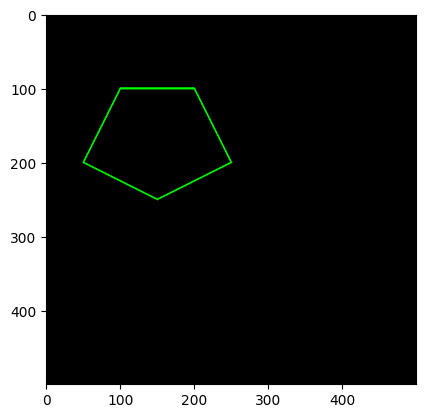

In [41]:
import cv2
import numpy as np

# Create a blank image (black background)
image = np.zeros((500, 500, 3), dtype=np.uint8)

# Define the vertices of the polygon
# Each vertex is a tuple of (x, y) coordinates
vertices = np.array([[100, 100], [200, 100], [250, 200], [150, 250], [50, 200]], dtype=np.int32)

# Reshape the vertices array to the shape (number of vertices, 1, 2)
vertices = vertices.reshape((-1, 1, 2))

# Draw the polygon on the image
# Parameters: image, vertices, isClosed, color, thickness
cv2.polylines(image, [vertices], isClosed=True, color=(0, 255, 0), thickness=2)

# Display the image
plt.imshow( image)


In [46]:
# Step 1: Create the list of numbers
numbers = [9991, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Step 2: Open the file in write mode
with open('/tmp/numbers.txt', 'w') as file:
    # Step 3: Convert the list to a space-separated string and write to the file
    file.write(' '.join(map(str, numbers)))

# Step 4: The file is automatically closed when using the 'with' statement


In [70]:
a0=r'/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/forObjectDetect_PACSDataInLabelmeFormatConvert2YoloFormat/301PACS02-2401020402.01/frm-0001.png'
newImagePath=r'/mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/yoloDataset01/301PACS02-2401020402.01_frm-0001.png'
a0=pathlib.Path(a0)
image_file=a0
newImagePath=pathlib.Path(newImagePath)

#shutil.copy2(a0, newImagePath)

In [72]:
allRects=[[1,2,3,4]]
saveImageAndLabelsToTargetPath(outputYoloFolder, image_file, allRects)


debug:outputYoloPath= /mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/yoloDataset01
debug:newImagePath= /mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/yoloDataset01/301PACS02-2401020402.01_frm-0001.png
File copied from /mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/forObjectDetect_PACSDataInLabelmeFormatConvert2YoloFormat/301PACS02-2401020402.01/frm-0001.png to  /mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/yoloDataset01/301PACS02-2401020402.01_frm-0001.png with metadata
debug: end of file create  /mnt/f/241129-zhipu-thyroid-datas/01-mini-batch/yoloDataset01/301PACS02-2401020402.01_frm-0001.png


0

In [75]:
a2=list(3,4)

TypeError: list expected at most 1 argument, got 2